In [1]:
import os
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np

In [2]:
# 分類するクラス
classes = ['Field', 'Undiscovered', 'Bug', 'Amorphous', 'Dragon', 'Fairy', 'Mineral', 
           'Flying', 'Grass', 'Human-Like', 'Monster', 'Water']

nb_classes = len(classes)

img_width, img_height = 150, 150

# トレーニング用とバリデーション用の画像格納先
train_data_dir = 'AllDataSet/train'
validation_data_dir = 'AllDataSet/validation'

# 今回はトレーニング用に3206枚、バリデーション用に2849枚の画像を用意した。
nb_train_samples = 3206
nb_validation_samples = 2849

batch_size = 16
nb_epoch = 10

In [3]:
def vgg_model_maker():
    """ VGG16のモデルをFC層以外使用。FC層のみ作成して結合して用意する """

    # VGG16のロード。FC層は不要なので include_top=False
    input_tensor = Input(shape=(img_width, img_height, 3))
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

    # FC層の作成
    top_model = Sequential()
    top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(nb_classes, activation='softmax'))

    # VGG16とFC層を結合してモデルを作成
    model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

    return model

In [4]:
def image_generator():
    """ ディレクトリ内の画像を読み込んでトレーニングデータとバリデーションデータの作成 """
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        zoom_range=0.2,
        horizontal_flip=True)

    validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        color_mode='rgb',
        classes=classes,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True)

    validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        color_mode='rgb',
        classes=classes,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True)

    return (train_generator, validation_generator)

In [5]:
result_dir = 'results'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

In [7]:
# モデル作成
vgg_model = vgg_model_maker()

# 最後のconv層の直前までの層をfreeze
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# 多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
                metrics=['accuracy'])

# 画像のジェネレータ生成
train_generator, validation_generator = image_generator()

# Fine-tuning

history = vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=int(nb_train_samples/batch_size),
    epochs=nb_epoch,
    validation_data=validation_generator,
    validation_steps=int(nb_validation_samples/batch_size)
)

vgg_model.save_weights(os.path.join(result_dir, 'finetuning.h5'))

Found 3206 images belonging to 12 classes.
Found 2849 images belonging to 12 classes.
Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 2.3512 - accuracy: 0.2423

/Users/watanabeshingo/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


200/200 [==============================] - 655s 3s/step - loss: 2.3512 - accuracy: 0.2423 - val_loss: 2.2719 - val_accuracy: 0.2584
Epoch 2/10
200/200 [==============================] - 638s 3s/step - loss: 2.1420 - accuracy: 0.2900 - val_loss: 2.1182 - val_accuracy: 0.2791
Epoch 3/10
200/200 [==============================] - 639s 3s/step - loss: 1.9424 - accuracy: 0.3451 - val_loss: 2.0675 - val_accuracy: 0.3111
Epoch 4/10
200/200 [==============================] - 620s 3s/step - loss: 1.6414 - accuracy: 0.4511 - val_loss: 1.9523 - val_accuracy: 0.3673
Epoch 5/10
200/200 [==============================] - 603s 3s/step - loss: 1.3118 - accuracy: 0.5665 - val_loss: 1.9489 - val_accuracy: 0.3806
Epoch 6/10
200/200 [==============================] - 613s 3s/step - loss: 1.0090 - accuracy: 0.6705 - val_loss: 2.1709 - val_accuracy: 0.3901
Epoch 7/10
200/200 [==============================] - 584s 3s/step - loss: 0.7404 - accuracy: 0.7655 - val_loss: 2.2660 - val_accuracy: 0.4277
Epoch 8/10

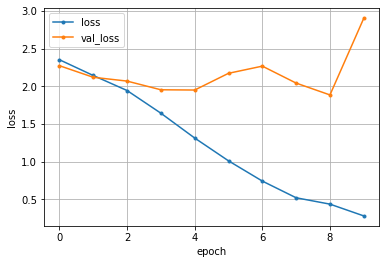

In [9]:
import matplotlib.pyplot as plt
loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

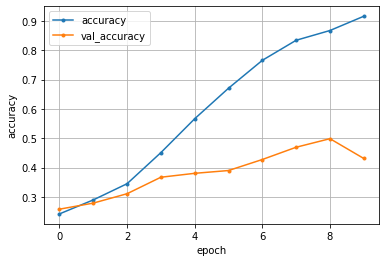

In [11]:
loss     = history.history['accuracy']
val_loss = history.history['val_accuracy']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='accuracy')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_accuracy')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()